In [1]:
import pandas as pd 
from os import listdir

In [2]:
# Read csv filenames 
files = [name for name in listdir() if 'csv' in name]
fileName = files[0]
fileName = '866192035921210_FILDER.csv'

In [3]:
# Read a file as dataframe 
df = pd.read_csv(fileName)

# Drop all Unnamed Columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Available columns 
df.columns.values

#Check Datatypes 
df.dtypes

id                       int64
receive_time            object
velocity               float64
engine_status            int64
main_battery_status      int64
ac_status                int64
voltage                  int64
satellite_number         int64
gps_availability         int64
gsm_strength             int64
row_status               int64
created_at              object
latitude_degree        float64
longitude_degree       float64
travel_distance_km     float64
fuel_litre             float64
fuel_type                int64
fuel_stability           int64
dtype: object

In [4]:
# Fixing the datatype 
df['receive_time'] = pd.to_datetime(df['receive_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

In [5]:
df.head()

,id,receive_time,velocity,engine_status,main_battery_status,ac_status,voltage,satellite_number,gps_availability,gsm_strength,row_status,created_at,latitude_degree,longitude_degree,travel_distance_km,fuel_litre,fuel_type,fuel_stability
0,172652,2018-03-01 00:04:25,0.0,0,1,0,3423,0,0,22,1,2018-03-01 00:04:26,23.71386,90.43449,0.0,18.272164,0,0
1,172653,2018-03-01 00:09:27,0.0,0,1,0,3423,0,0,22,1,2018-03-01 00:09:27,23.71386,90.43449,0.0,18.272164,0,0
2,172654,2018-03-01 00:14:29,0.0,0,1,0,3423,0,0,22,1,2018-03-01 00:14:30,23.71386,90.43449,0.0,18.272164,0,0
3,172655,2018-03-01 00:19:31,0.0,0,1,0,3423,0,0,22,1,2018-03-01 00:19:32,23.71386,90.43449,0.0,18.272164,0,0
4,172656,2018-03-01 00:24:32,0.0,0,1,0,3423,0,0,22,1,2018-03-01 00:24:32,23.71386,90.43449,0.0,18.272164,0,0


In [6]:
# Create New Columns to find Time_difference_between_consecutive_creation_of_data
df['time_difference'] = df['created_at'] - df['created_at'].shift()

# Convert time difference to seconds 
df['time_difference'] = df['time_difference'].dt.total_seconds()

# Create New Columns - diff between fuel_data
df['fuel_difference'] = df['fuel_litre'] - df['fuel_litre'].shift()

# Difference Between voltages 
df['voltage_difference'] = df['voltage'] - df['voltage'].shift()

In [7]:
# Drop the rows with NAN values 
df = df.dropna(axis=0, how='any')
df = df.loc[df['fuel_litre'] < 40 ]
df = df.loc[df['fuel_litre'] > 4 ]

In [8]:
df['travel_distance_km'].corr(df['fuel_difference'])

0.0016571913937980184

Populating the interactive namespace from numpy and matplotlib


/home/clueless/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


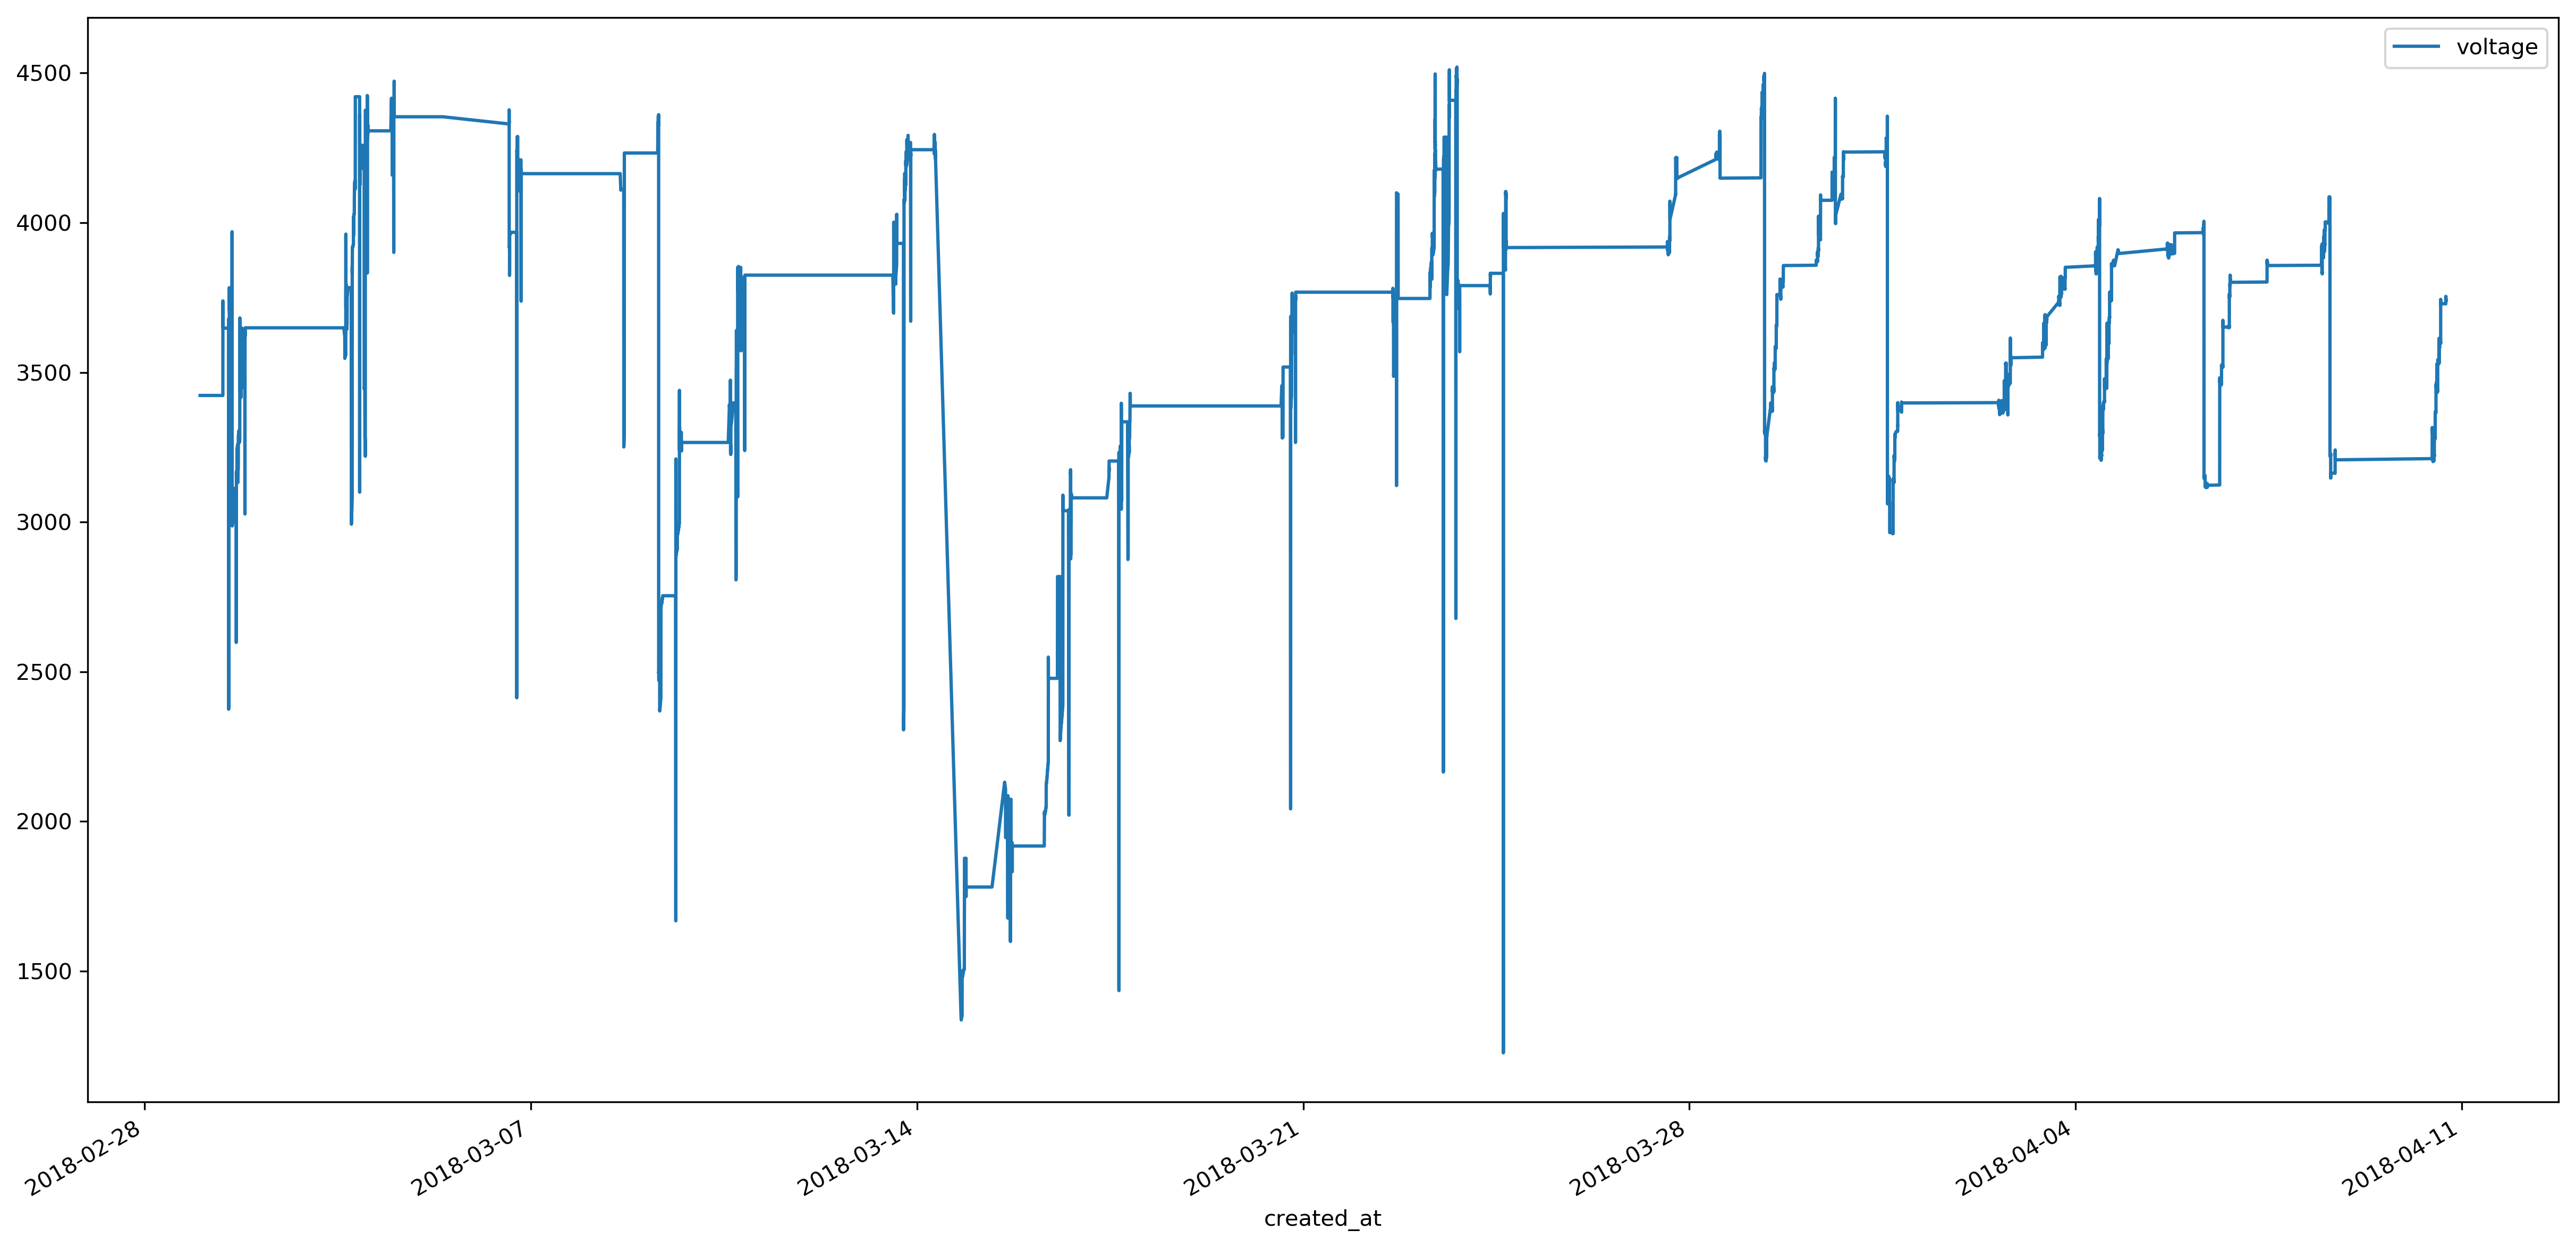

In [9]:
%pylab inline 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
def standardize(series):
    return (series - series.mean())/series.std(ddof=0)
len(standardize(df['voltage']))
df.plot(x = 'created_at',y=['voltage'])

In [10]:
df[1726:1800]

,id,receive_time,velocity,engine_status,main_battery_status,ac_status,voltage,satellite_number,gps_availability,gsm_strength,...,created_at,latitude_degree,longitude_degree,travel_distance_km,fuel_litre,fuel_type,fuel_stability,time_difference,fuel_difference,voltage_difference
1805,174457,2018-03-03 15:07:20,42.04040,1,1,1,3548,13,1,22,...,2018-03-03 15:07:20,23.684105,90.423615,0.781718,18.929262,0,0,52.0,-0.013430,1.0
1806,174458,2018-03-03 15:07:33,18.64960,1,1,1,3549,13,1,19,...,2018-03-03 15:07:33,23.683132,90.422240,0.176858,18.915821,0,0,13.0,-0.013440,1.0
1807,174459,2018-03-03 15:07:48,30.76170,1,1,1,3549,14,1,16,...,2018-03-03 15:07:48,23.682976,90.421730,0.054848,18.915821,0,0,15.0,0.000000,0.0
1808,174460,2018-03-03 15:08:05,26.96510,1,1,1,3549,14,1,31,...,2018-03-03 15:08:05,23.682770,90.420235,0.153943,18.915821,0,0,17.0,0.000000,0.0
1809,174461,2018-03-03 15:08:20,39.92910,1,1,1,3549,13,1,31,...,2018-03-03 15:08:20,23.682720,90.419235,0.101977,18.915821,0,0,15.0,0.000000,0.0
1810,174462,2018-03-03 15:08:37,30.59500,1,1,1,3550,14,1,31,...,2018-03-03 15:08:37,23.682617,90.417366,0.190656,18.902371,0,0,17.0,-0.013450,1.0
1811,174463,2018-03-03 15:08:52,54.07840,1,1,1,3550,14,1,24,...,2018-03-03 15:08:52,23.682423,90.415940,0.146898,18.902371,0,0,15.0,0.000000,0.0
1812,174464,2018-03-03 15:09:09,7.55616,1,1,1,3550,14,1,19,...,2018-03-03 15:09:09,23.681871,90.414420,0.166312,18.902371,0,0,17.0,0.000000,0.0
1813,174465,2018-03-03 15:09:24,12.77880,1,1,1,3550,14,1,26,...,2018-03-03 15:09:24,23.681711,90.414116,0.035792,18.902371,0,0,15.0,0.000000,0.0
1814,174466,2018-03-03 15:09:41,15.79760,1,1,1,3550,15,1,26,...,2018-03-03 15:09:41,23.681390,90.413630,0.061116,18.902371,0,0,17.0,0.000000,0.0


In [11]:
series = pd.Series([3712,3712,3712,3712,3712,3712,3712,3712,3712,3713])

In [13]:
series.var()

0.1